### We need to implement the histogram equalization for the images 

In [1]:
import imageio
import cv2
import numpy as np
from matplotlib import pyplot as plt

def HSI_to_rgb(img):
    h = img[:,:, 0]
    s = img[:,:, 1]
    i = img[:,:, 2]    

    h1 = h < 1/3 * 2 * np.pi
    h2 = (1/3 * 2 * np.pi <= h) & (h < 2/3 * 2 * np.pi)
    h3 = 2/3 * 2 * np.pi <= h    

    r = np.zeros_like(h)
    g = np.zeros_like(h)
    b = np.zeros_like(h)
    h_curr = np.zeros_like(h)

    # case 1
    h_curr[h1] = h[h1]
    b[h1] = i[h1] * (1 - s[h1])
    r[h1] = i[h1] * (1 + (s[h1] * np.cos(h_curr[h1])) / (np.cos(np.pi/3 - h_curr[h1])))
    g[h1] = 3 * i[h1] - (r[h1] + b[h1])

    # case 2    
    h_curr[h2] = h[h2] - (2/3 * np.pi)

    r[h2] = i[h2] * (1 - s[h2])
    g[h2] = i[h2] * (1 + (s[h2] * np.cos(h_curr[h2])) / (np.cos(np.pi/3 - h_curr[h2])))
    b[h2] = 3 * i[h2] - (r[h2] + g[h2])

    # case 3
    h_curr[h3] = h[h3] - (4/3 * np.pi)

    g[h3] = i[h3] * (1 - s[h3])
    b[h3] = i[h3] * (1 + (s[h3] * np.cos(h_curr[h3])) / (np.cos(np.pi/3 - h_curr[h3])))
    r[h3] = 3 * i[h3] - (g[h3] + b[h3])
    
    return np.stack((r,g,b),axis=2)

def rgb_to_HSI(img):

    with np.errstate(divide="ignore", invalid="ignore"):

        # load image with 32 floating point type
        rgb = np.float32(img)/255

        # Separating RGB    
        r = rgb[:,:,0]
        g = rgb[:,:,1]
        b = rgb[:,:,2]
        r = r.astype(np.float32)

        # Intensity
        intensity = (r+b+g)/3

        # Saturation
        min = np.minimum(np.minimum(r,g),b)
        sat = 1 - (3/(r+g+b+0.0000001)*min)

        # Hue
        hue = np.arccos((0.5*((r-g)+(r-b)))/((np.sqrt((r-g)**2+(r-b)*(g-b)))))
        hue[b>g] = 2*np.pi - hue[b>g]        

        return np.stack((hue,sat,intensity),axis=2)


def read_img(img_path):
    return imageio.imread(img_path)



In [2]:
img_path = "../../../images/used_images/light_dark/"
img_name = "DSC_0015.jpg"
#img_path = "./"
#img_name = "lenna.png"

img_rgb = read_img(img_path+img_name)
print(img_rgb.shape)

# Converting RGB to HSI
img_hsi = rgb_to_HSI(img_rgb)    

# Converting back to RGB
img_back_rgb = HSI_to_rgb(img_hsi)

C:\Users\sebastian\AppData\Local\Temp\ipykernel_26964\855256447.py:70: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(img_path)


(4000, 6000, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\sebastian\miniconda3\envs\cv701\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


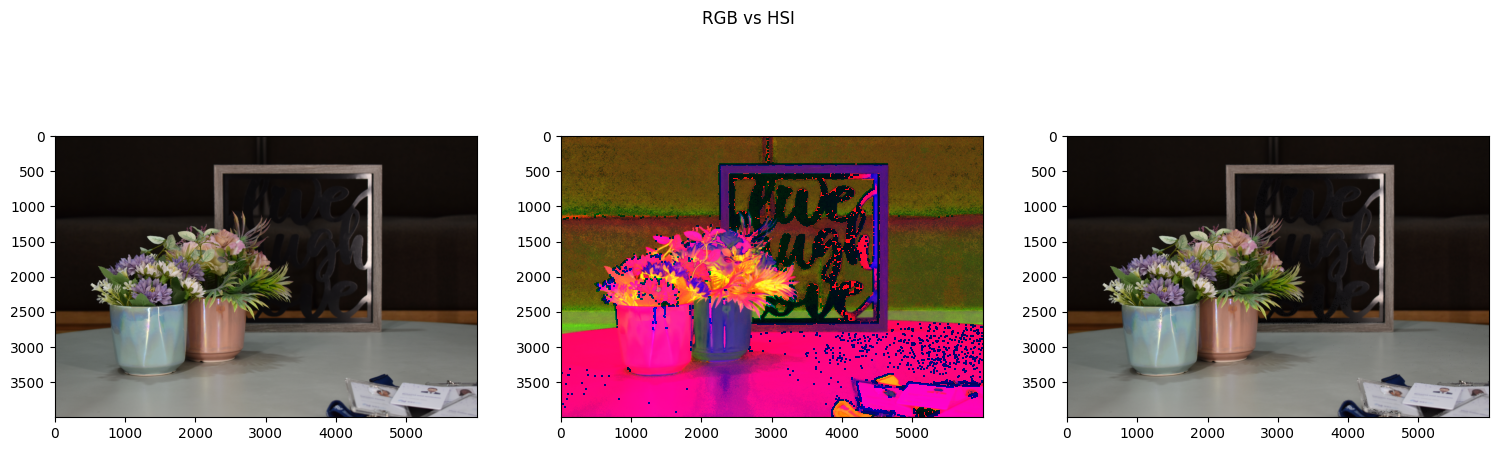

In [3]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(img_rgb)
axs[1].imshow(img_hsi)
axs[2].imshow(img_back_rgb)
fig.suptitle('RGB vs HSI')
fig.set_size_inches(18.5, 5.5)
plt.show()

In [4]:
def create_histogram_rgb(img=None):        
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('RGB Histogram and corresponding image')
    fig.set_size_inches(18.5, 5.5)

    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        axs[0].plot(histr, color = col)                
    axs[1].imshow(img)
    plt.show()

def create_histogram_hsi(img_hsi):

    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Intensity Histogram in HSI color space and corresponding image')
    fig.set_size_inches(18.5, 5.5)

    histr = cv2.calcHist([img_hsi],[2],None,[256],[0,1])
    axs[0].plot(histr)    
    axs[1].imshow(img_hsi)
    plt.plot()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


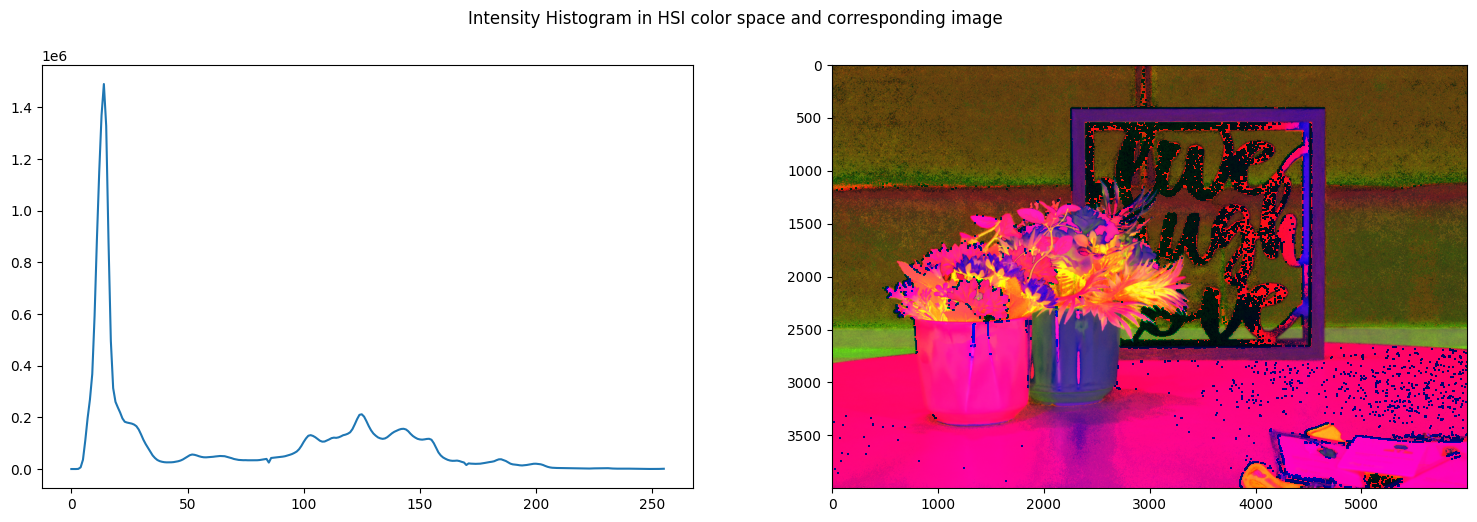

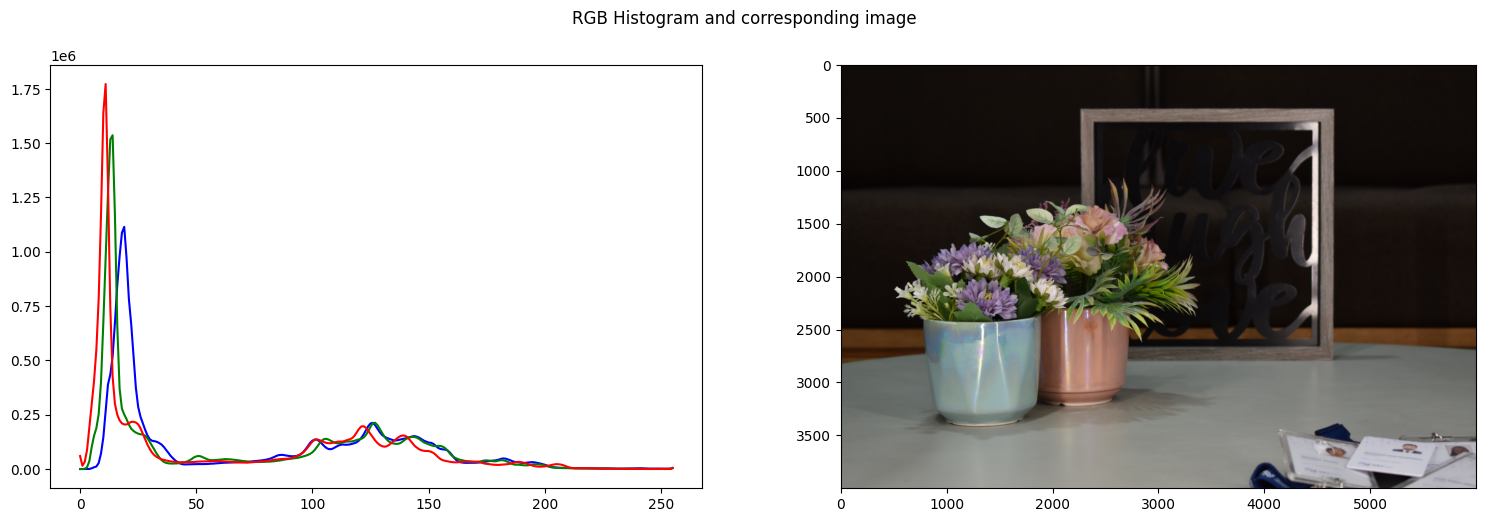

In [5]:
# Creating the histogram for intensity channel
create_histogram_hsi(img_hsi)

# Creating the histogram for every channel
create_histogram_rgb(img_rgb)

### Equalization on HSI

The idea of equalization is to make the above histogram similar to a uniform distribution

In [6]:
img_hsi_equalized = img_hsi.copy()
src_8 = np.uint8(img_hsi_equalized[:,:,2]*255)
dst = cv2.equalizeHist(src_8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


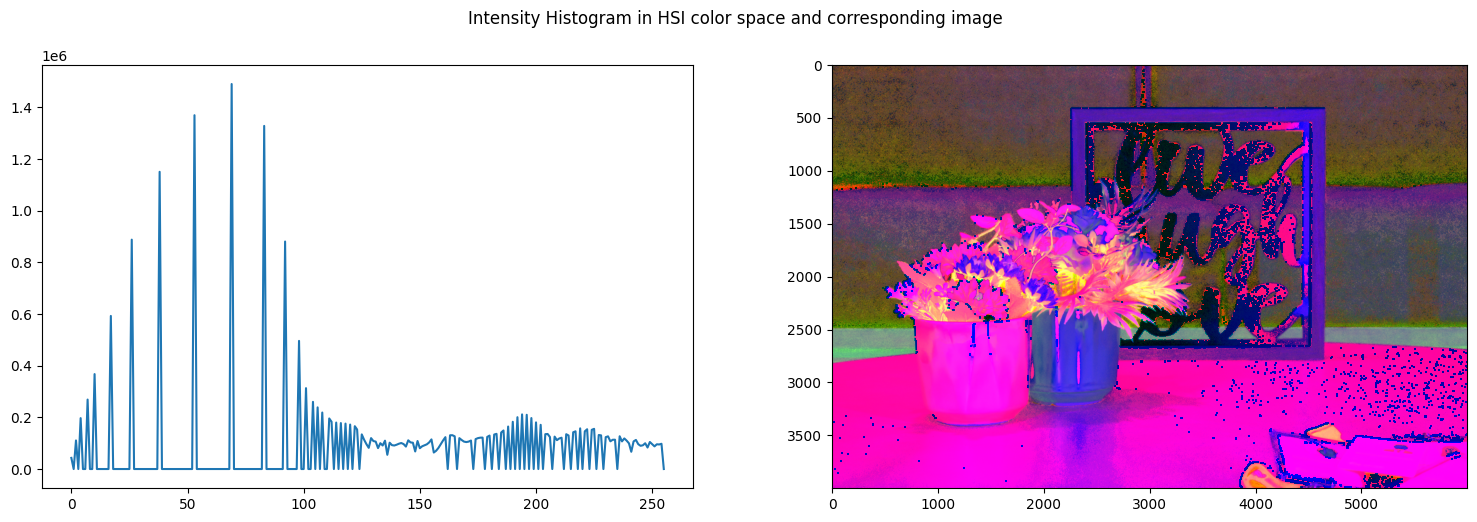

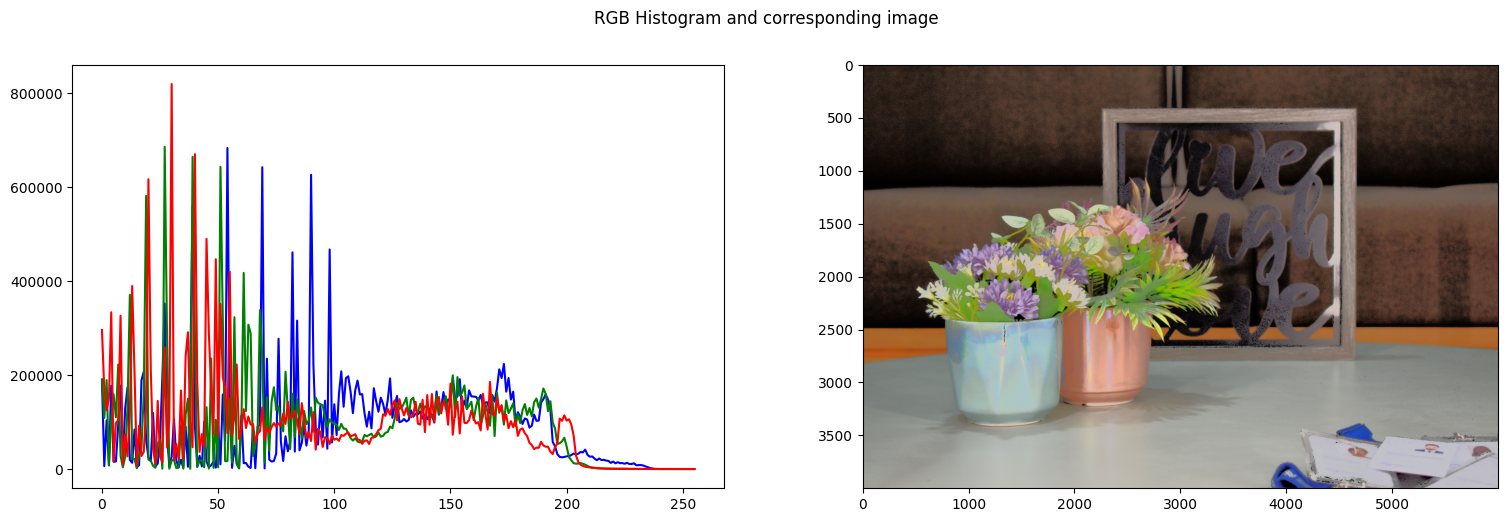

In [7]:
img_hsi_equalized[:,:,2] = np.float32(dst/255)

create_histogram_hsi(img_hsi_equalized)

new_img = HSI_to_rgb(img_hsi_equalized)
new_img_8 = np.uint8(new_img*255/np.max(new_img.flatten())) # clip the values to 0 to 255

create_histogram_rgb(new_img_8)

In [8]:
def compare(img1, img2, titles):
    res = np.hstack((img1,img2)) #stacking images side-by-side
    plt.figure(figsize=(20,10))
    plt.title('{} vs {}'.format(titles[0],titles[1]))
    plt.imshow(res,cmap='gray')

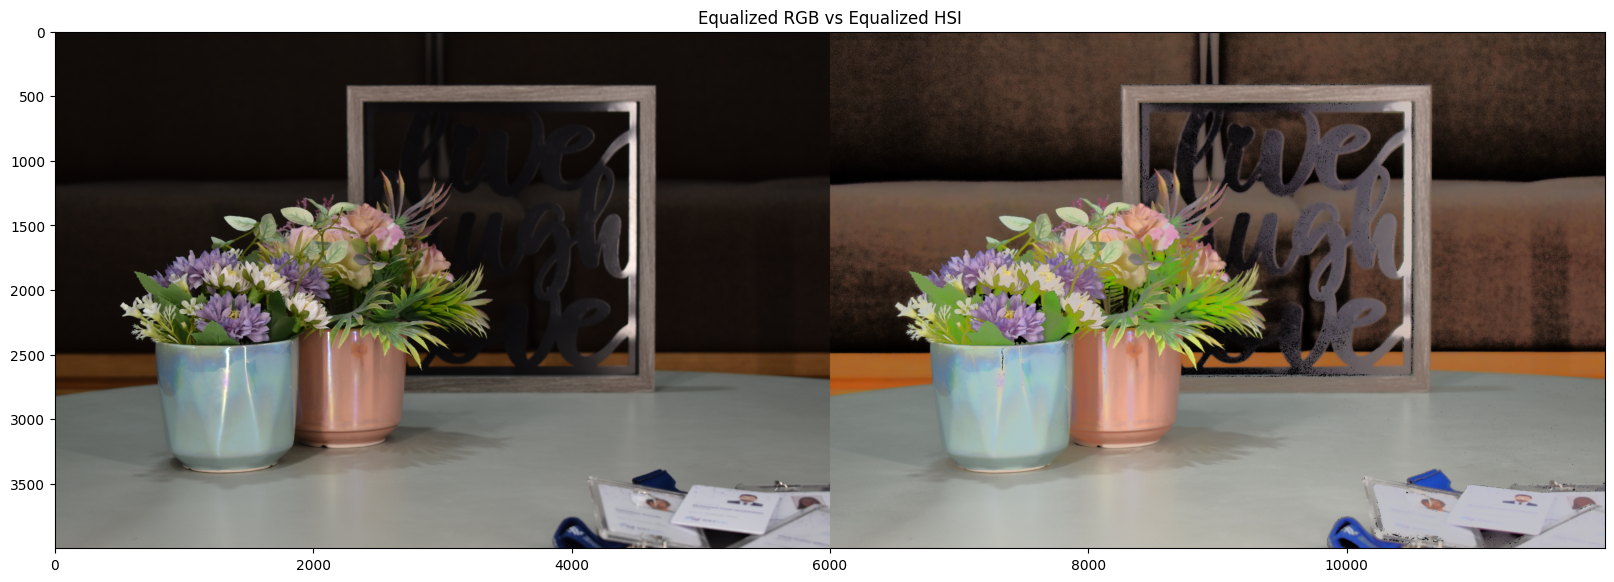

In [9]:
compare(img_rgb, new_img_8, ["Equalized RGB", "Equalized HSI"])

# Contrast stretching - Gamma


In [10]:
def gamma(img, gamma):    
    return np.power(img, 1/gamma)

def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

In [11]:
img_rgb_gamma = img_rgb.copy()/255

gamma05 = gammaCorrection(img_rgb, 0.5)
gamma15 = gammaCorrection(img_rgb, 1.5)

#print(max(test.flatten()))


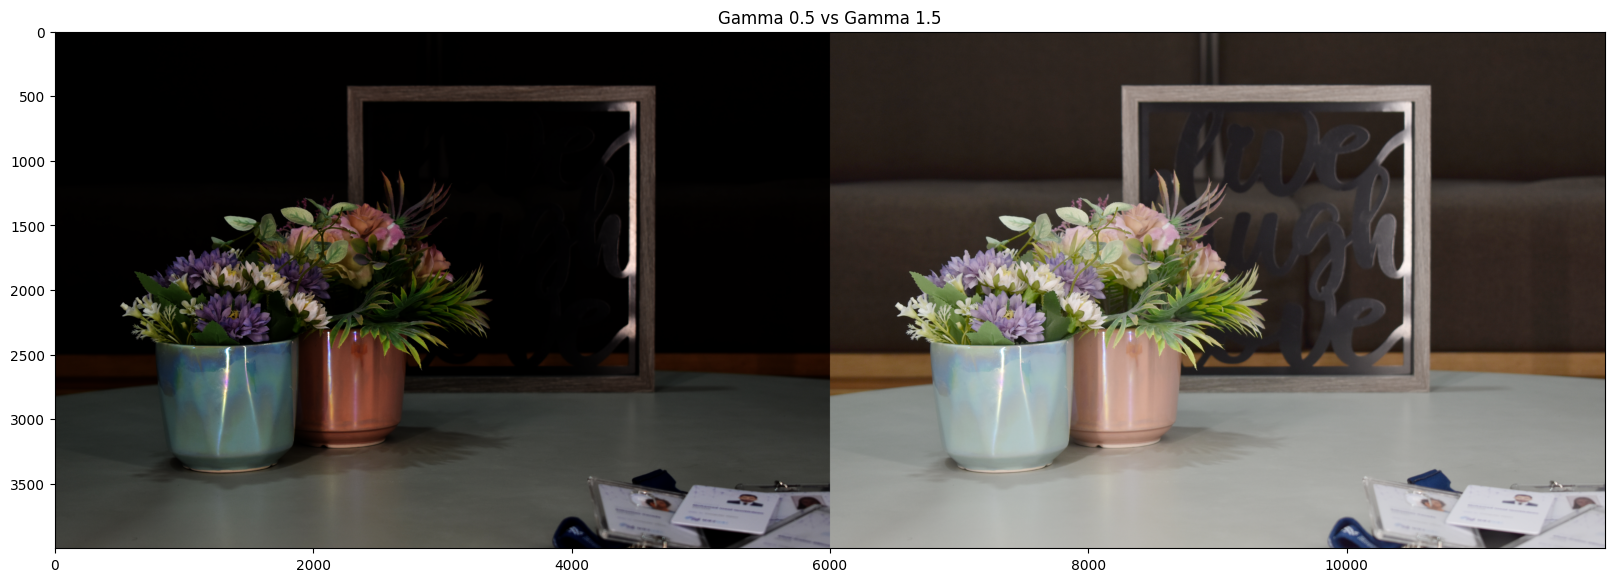

In [12]:
compare(gamma05, gamma15, ["Gamma 0.5", "Gamma 1.5"])

## Contrast Stretching - alpha & beta

In [16]:
img_rgb_ab = img_rgb.copy()/255

alpha = 1.5
beta = 0.5
new_img_a = np.clip(alpha*img_rgb_ab + beta, 0, 1)

img_rgb_ab = img_rgb.copy()/255

alpha = 0.5
beta = 0.05
new_img_b = np.clip(alpha*img_rgb_ab + beta, 0, 1)


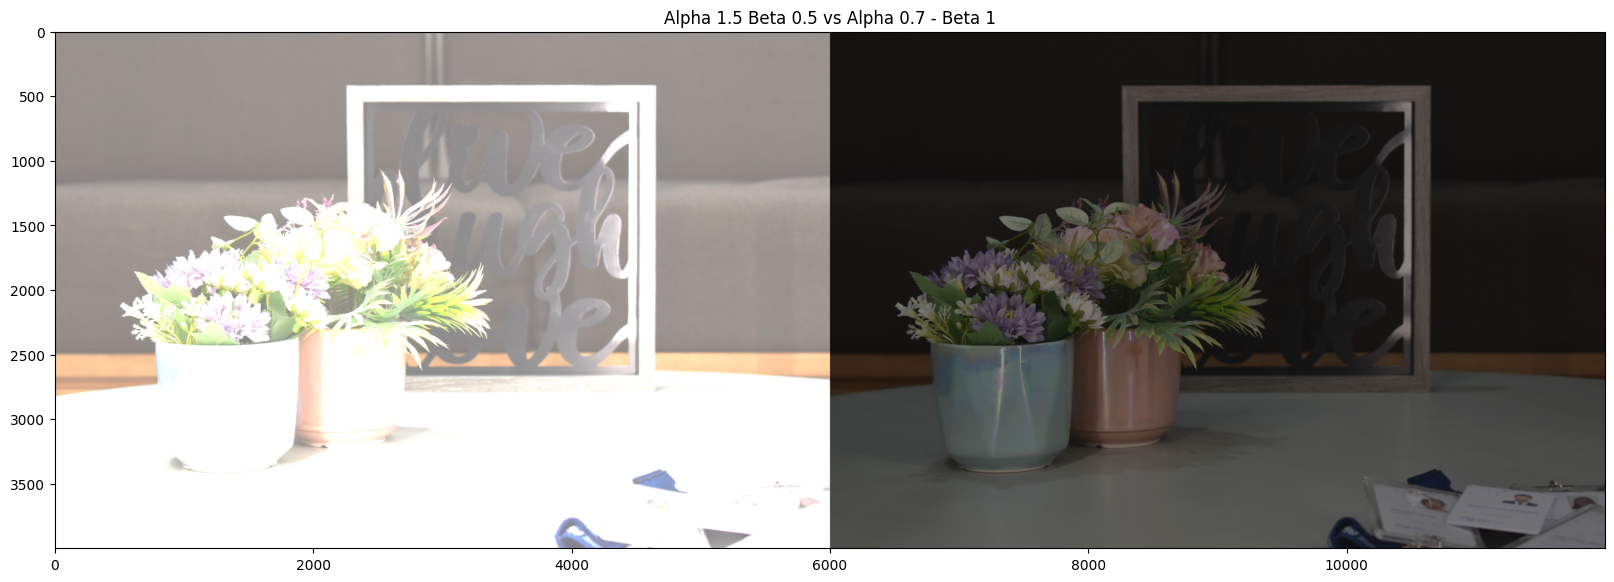

In [17]:
compare(new_img_a, new_img_b, ["Alpha 1.5 Beta 0.5", "Alpha 0.7 - Beta 1"])